In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# KoBERT finetuning

In [ ]:
!pip install ipywidgets  # for vscode
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-o2a0_k6k
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-o2a0_k6k
     |████████████████████████████████| 132 kB 4.1 MB/s 
     |████████████████████████████████| 344 kB 32.8 MB/s 
     |████████████████████████████████| 49.1 MB 1.5 MB/s 
     |████████████████████████████████| 4.5 MB 54.1 MB/s 
     |████████████████████████████████| 1.2 MB 54.1 MB/s 
     |████████████████████████████████| 4.2 MB 53.0 MB/s 
     |████████████████████████████████| 596 kB 64.8 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 6.6 MB 53.5 MB/s 
     |████████████████████████████████| 79 kB 9.0 MB/s 
     |██████████

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [ ]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
## CPU
#device = torch.device("cpu")

## GPU
device = torch.device("cuda:0")

In [ ]:
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
import pandas as pd
dataset_train = pd.read_excel("/content/drive/MyDrive/Python/assignment/nlp/train_2.xlsx",index_col=0)
dataset_val = pd.read_excel("/content/drive/MyDrive/Python/assignment/nlp/validation_2.xlsx",index_col=0)

In [ ]:
train_list = []
for ques, label in zip(dataset_train['사람'], dataset_train['label'])  :
    data = []   
    data.append(ques)
    data.append(label)

    train_list.append(data)

In [ ]:
val_list = []
for ques, label in zip(dataset_val['사람'], dataset_val['label'])  :
    data = []   
    data.append(ques)
    data.append(label)

    val_list.append(data)

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
## Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [ ]:
data_train = BERTDataset(train_list, 0, 1, tok, max_len, True, False)
data_val = BERTDataset(val_list, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=len(dataset_val['label'].unique()),
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/106 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.188918113708496 train acc 0.046875
epoch 1 train acc 0.2886068825042882


  0%|          | 0/14 [00:00<?, ?it/s]

epoch 1 test acc 0.4836309523809524


  0%|          | 0/106 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.4019399881362915 train acc 0.578125


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),'/content/drive/MyDrive/Python/assignment/nlp/happy.pt')

### 코랩 연결 끊김 방지 
function ClickConnect(){ <br>
    console.log("코랩 연결 끊김 방지");<br> 
    document.querySelector<br>("colab-toolbar-button#toolbar-add-code").click()<br> 
}<br>
setInterval(ClickConnect, 30 * 60 * 1000)<br>

In [ ]:
function ClickConnect(){ console.log("코랩 연결 끊김 방지"); document.querySelector("colab-toolbar-button#toolbar-add-code").click() } setInterval(ClickConnect, 30 * 60 * 1000)

# 모델 평가하기

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Python/assignment/nlp/save_2.pt'))
model.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [ ]:
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=1, num_workers=5)
pred_y = []
for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        pred_y.append(out.cpu().detach().numpy().argmax())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/5130 [00:00<?, ?it/s]

In [ ]:
for (token_ids, valid_length, segment_ids, label) in val_dataloader:
  print(token_ids)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[   2, 3647, 3264,  ...,    1,    1,    1],
        [   2, 1370, 1680,  ...,    1,    1,    1],
        [   2, 3060, 7909,  ...,    1,    1,    1],
        ...,
        [   2, 2872,  517,  ..., 6217, 7088,    3],
        [   2, 1535, 2888,  ...,    1,    1,    1],
        [   2, 4797, 7188,  ...,    1,    1,    1]], dtype=torch.int32)
tensor([[   2, 4628, 7096,  ...,    1,    1,    1],
        [   2, 2095, 6493,  ...,    1,    1,    1],
        [   2, 3298, 7598,  ...,    1,    1,    1],
        ...,
        [   2, 2860, 6295,  ...,    1,    1,    1],
        [   2, 3489, 4495,  ...,    1,    1,    1],
        [   2, 1370, 2640,  ...,    1,    1,    1]], dtype=torch.int32)
tensor([[   2, 3419, 2353,  ...,    3,    1,    1],
        [   2, 3982, 1088,  ...,    1,    1,    1],
        [   2, 3096, 4760,  ...,    1,    1,    1],
        ...,
        [   2, 1370, 1434,  ...,    1,    1,    1],
        [   2, 1434, 5136,  ...,    1,    1,    1],
        [   2, 1375, 3220,  ...,    3

In [ ]:
label_dic = {name:value for name, value in zip(dataset_val['label'].unique(), dataset_val['감정_소분류'].unique())}
pred_y_label = [label_dic[i] for i in pred_y]
cm_label = [label_dic[i] for i in range(len(label_dic))]

NameError: ignored

In [ ]:
label_dic = {name:value for name, value in zip(dataset_val['label'].unique(), dataset_val['감정_소분류'].unique())}

In [ ]:
import pickle

with open('filename.pickle', 'wb') as handle:
    pickle.dump(label_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)

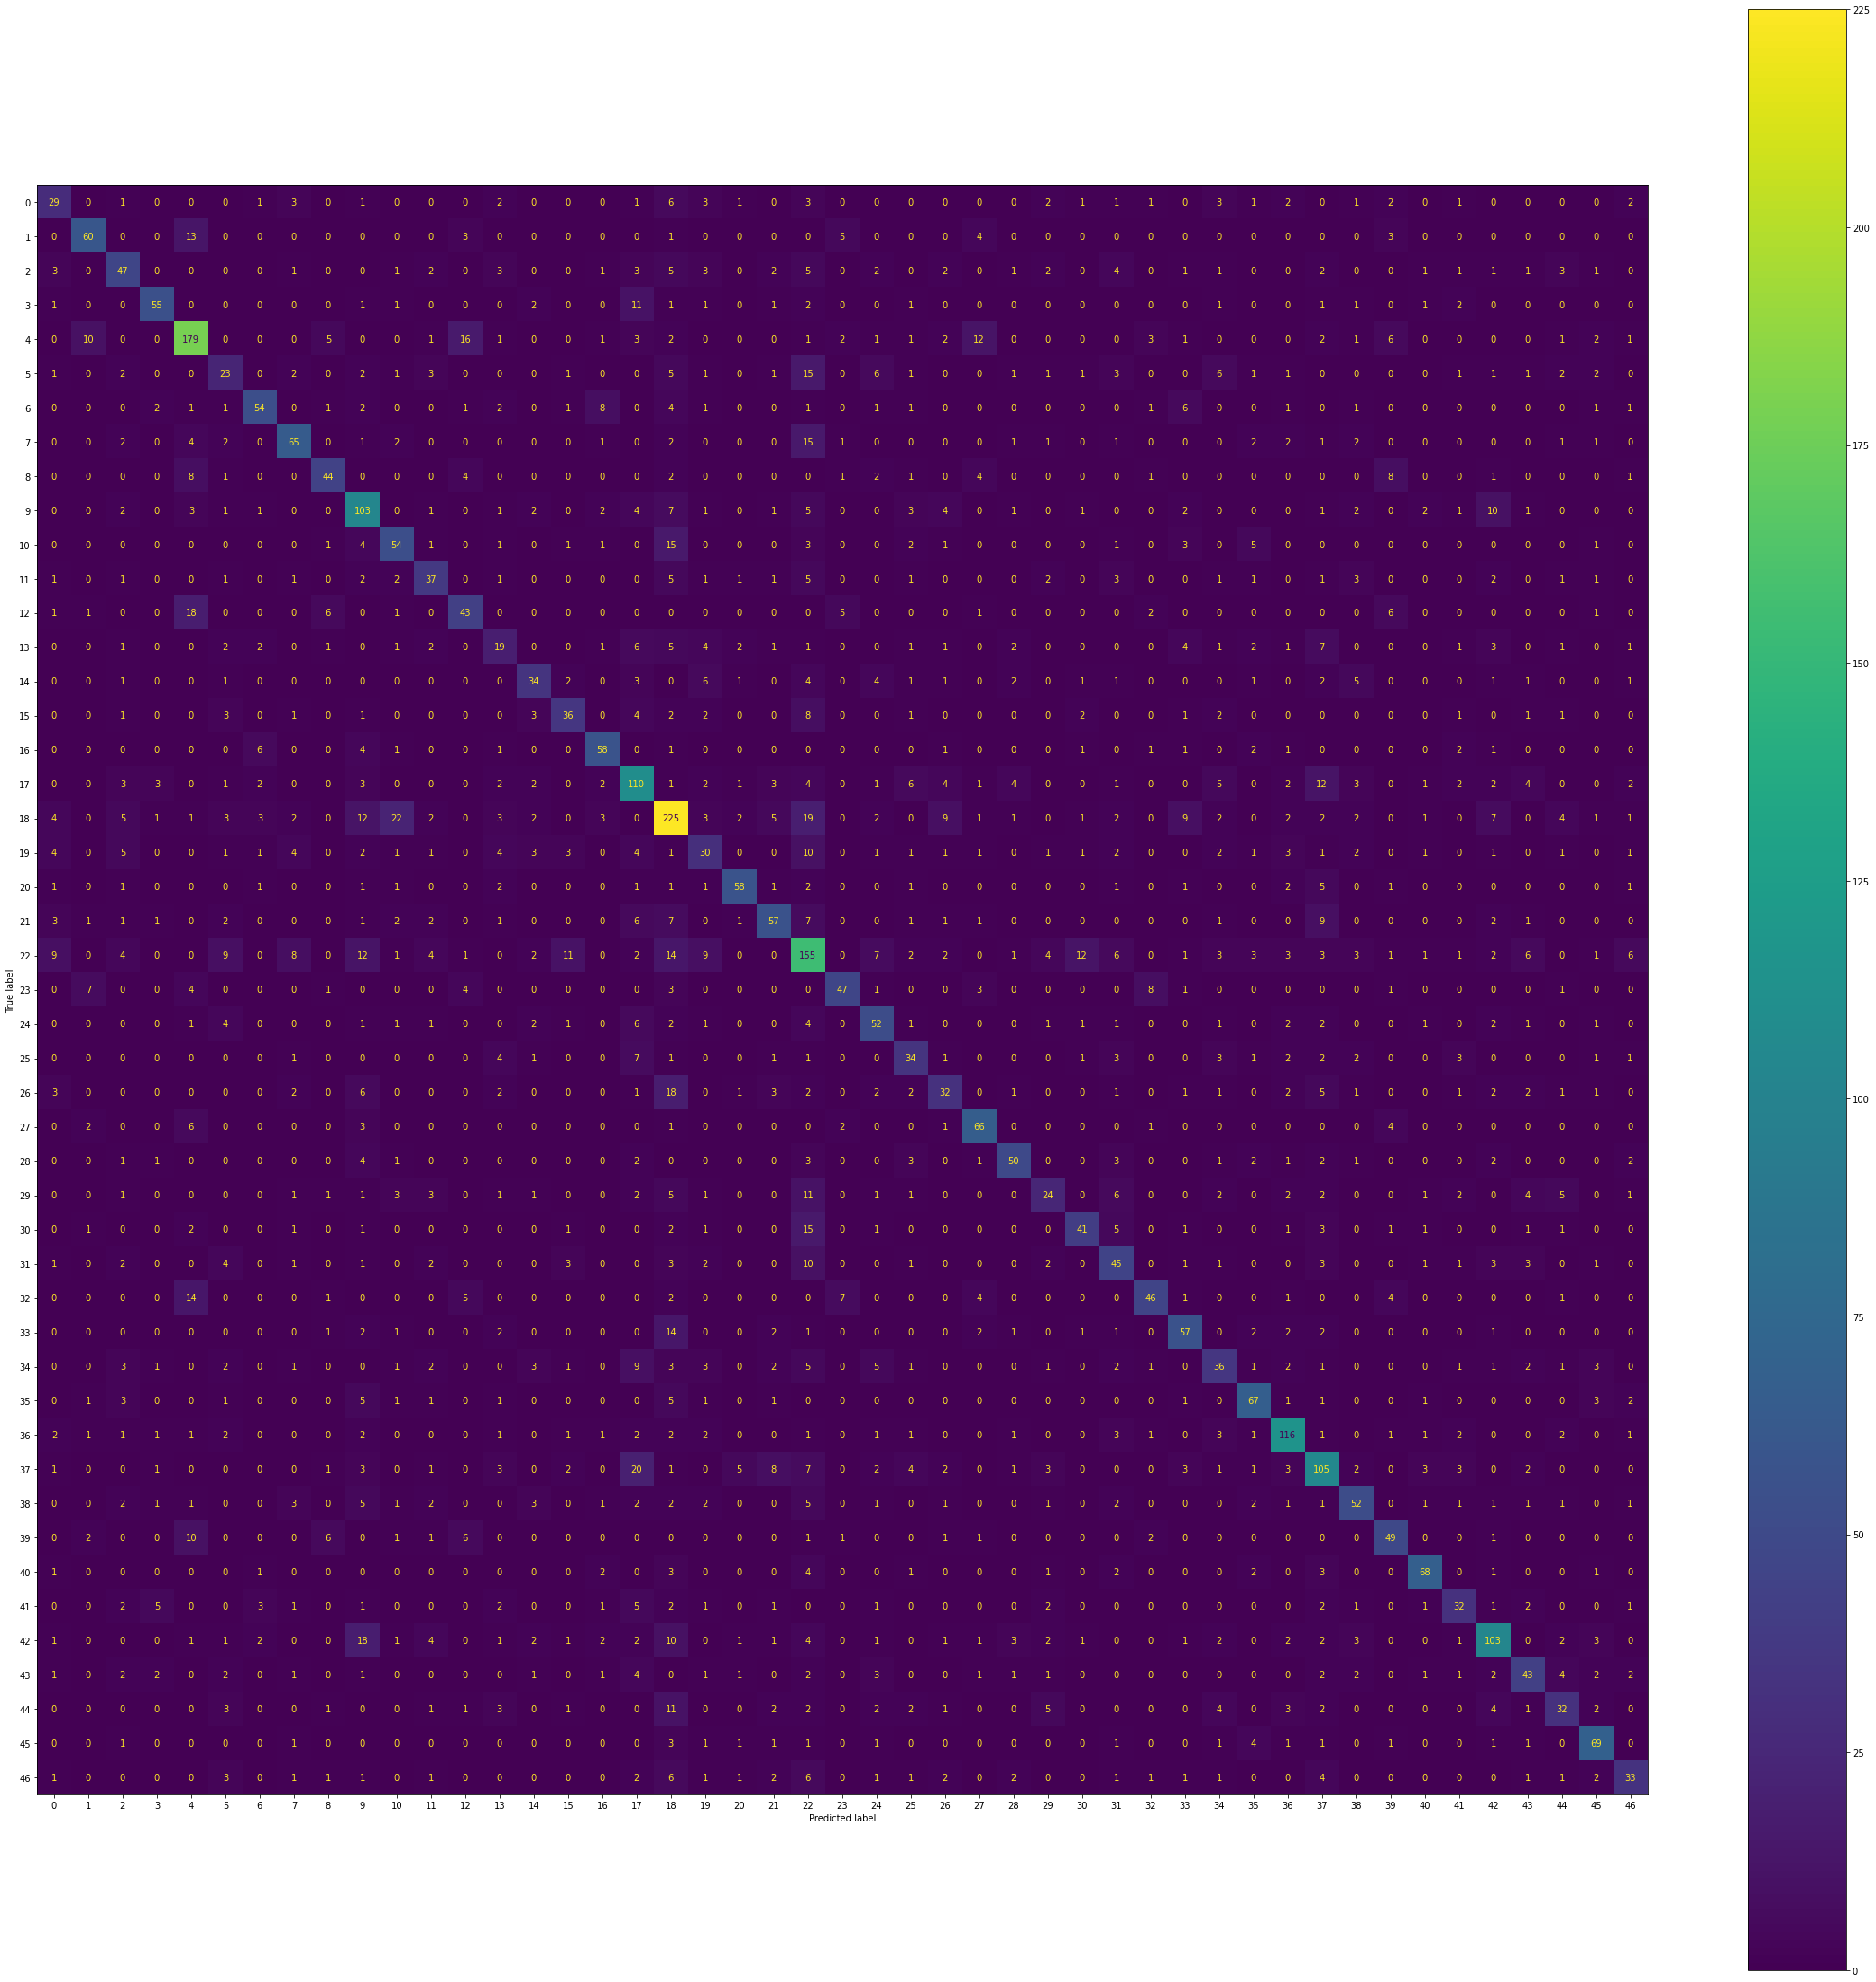

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

confusion_matrix = confusion_matrix(y_true=dataset_val['감정_소분류'], y_pred=pred_y_label, labels=cm_label) 

disp = ConfusionMatrixDisplay(confusion_matrix)
fig, ax = plt.subplots(figsize=(40,40))
disp.plot(ax=ax)
#plt.savefig('finbert.png')
plt.show()

In [ ]:
for i in range(len(label_dic)):
  for j in range(len(label_dic)):
    if confusion_matrix[i][i]/confusion_matrix[i].sum() < 0.5 and i!=j and confusion_matrix[i][j]/confusion_matrix[i].sum()>0.1:
      print(label_dic[i] +'(이)랑 '+label_dic[j]+'(은)는 나누기 애매합니다.')

낙담한(이)랑 슬픔(은)는 나누기 애매합니다.
상처(이)랑 슬픔(은)는 나누기 애매합니다.
안달하는(이)랑 불안(은)는 나누기 애매합니다.
염세적인(이)랑 슬픔(은)는 나누기 애매합니다.
우울한(이)랑 슬픔(은)는 나누기 애매합니다.
회의적인(이)랑 불안(은)는 나누기 애매합니다.


In [ ]:
dataset_val[dataset_val['감정_소분류']=='안달하는']

,상황키워드,감정_대분류,감정_소분류,사람,시스템,label,label2
166,"건강, 죽음",분노,안달하는,내가 간암으로 죽기 전에 아들이 결혼했으면 좋겠어서 안달이 나. 아들에게 선을 보라...,죽기 전에 아들이 결혼하는 모습을 보고 싶어 안달이 나시는군요. 아들에게 선을 보라...,26,2
182,학교폭력/따돌림,분노,안달하는,내가 어떻게 하면 우리 반 애들과 잘 어울릴 수 있을까? 나와 어울려주지 않아. 근...,반 친구들과 사이가 좋지 않으신가요? 반 친구들과 어울리고 싶은데 어떻게 해야 할지...,26,2
188,"직장, 업무 스트레스",분노,안달하는,상사가 자꾸 보고서를 채근해. 안절부절못하겠어. 응. 정말 안달 나고 스트레스받아.,상사의 재촉으로 마음이 불안하시군요. 많이 힘드실 것 같아요.,26,2
257,"재정, 은퇴, 노후준비",분노,안달하는,노후 자금으로 매달 삼백만 원은 필요한데 지금으로선 절반도 안 될 정도야. 어떡하지...,노후 자금이 부족해 고민이신 것 같아요. 이럴 때 무엇을 하시면 도움이 될까요? 씀...,26,2
285,대인관계,분노,안달하는,내가 아는 친구 중에 이번 코로나 사태로 인해 사정이 굉장히 딱해진 친구가 있어. ...,코로나로 인해 힘든 상황에 처한 친구가 있군요. 예전에 돈을 빌려줬던 친구에게 돈을...,26,2
...,...,...,...,...,...,...,...
4880,"건강, 죽음",분노,안달하는,요즘은 내가 너무 늙은 것 같아서 우울해. 손자가 넘어졌는데 빨리 일으켜주지도 못하...,몸이 예전 같지 않아서 마음이 안 좋으시겠어요. 지금 할 수 있는 것은 무엇일까요?...,26,2
4936,대인관계,분노,안달하는,이번에 신입생 환영회 갔다가 좋아하는 사람이 생겼어. 더 이야기를 나누고 싶은데 무...,좋은 소식이네요! 어떤 얘기로 말을 붙일지 모르겠군요. 학생회에 들어가서 그분과 가...,26,2
5012,"연애, 결혼, 출산",분노,안달하는,남자친구가 날 안 좋아하는 것 같아. 바쁘다고 연락도 잘 안 되고 애정 표현도 잘 ...,어떤 점이 그렇게 느껴지세요? 남자친구가 날 안 좋아하는 것 같아 안달이 나시는군요...,26,2
5124,학교폭력/따돌림,분노,안달하는,학교 친구들이 나만 계속 따돌려서 너무 무서워. 나랑만 대화를 하지 않고 무시하면서...,따돌림 때문에 두려우시군요. 조금 더 자세히 설명해 주시겠어요? 무시하고 괴롭힘 당...,26,2


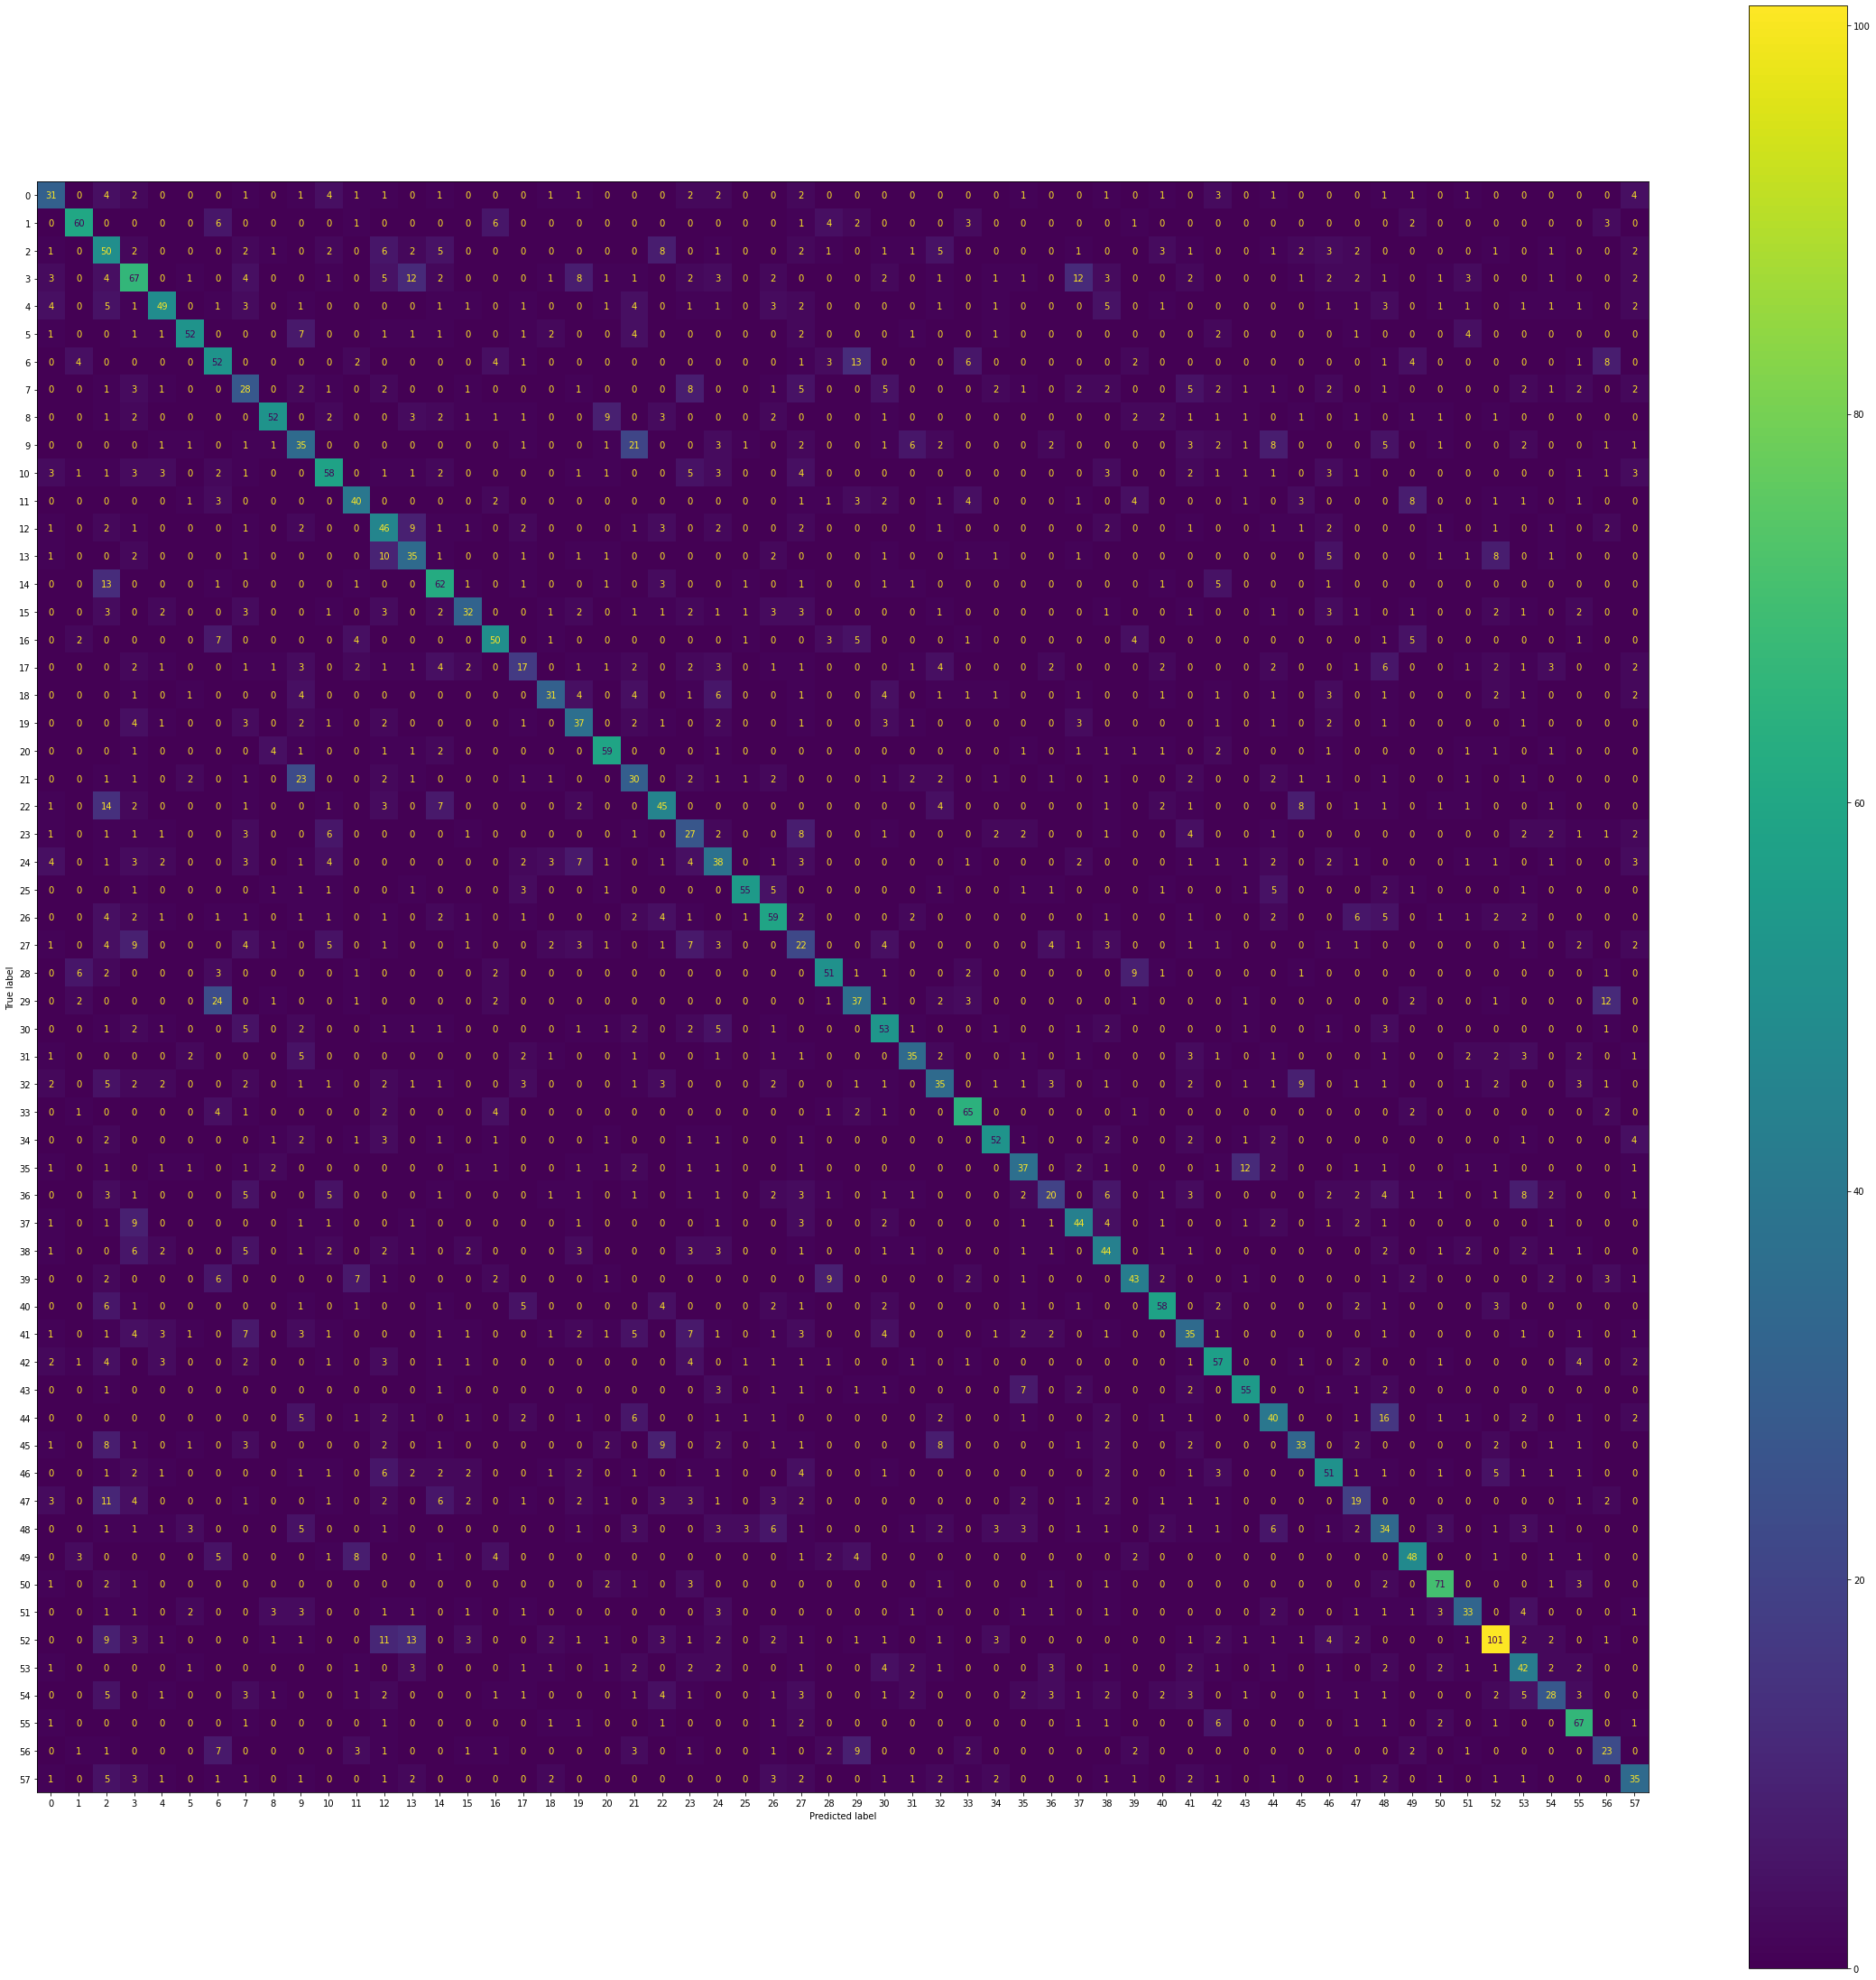

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

confusion_matrix = confusion_matrix(y_true=dataset_val['감정_소분류'], y_pred=pred_y_label, labels=cm_label) 

disp = ConfusionMatrixDisplay(confusion_matrix)
fig, ax = plt.subplots(figsize=(40,40))
disp.plot(ax=ax)
#plt.savefig('finbert.png')
plt.show()

In [ ]:
for i in range(len(label_dic)):
  for j in range(len(label_dic)):
    if confusion_matrix[i][i]/confusion_matrix[i].sum() < 0.5 and i!=j and confusion_matrix[i][j]/confusion_matrix[i].sum()>0.1:
      print(label_dic[i] +'(이)랑 '+label_dic[j]+'(은)는 나누기 애매합니다.')

노여워하는(이)랑 분노(은)는 나누기 애매합니다.
당황(이)랑 당혹스러운(은)는 나누기 애매합니다.
당황(이)랑 혼란스러운(은)는 나누기 애매합니다.
분노(이)랑 노여워하는(은)는 나누기 애매합니다.
불안(이)랑 걱정스러운(은)는 나누기 애매합니다.
비통한(이)랑 슬픔(은)는 나누기 애매합니다.
슬픔(이)랑 고립된(은)는 나누기 애매합니다.
신이 난(이)랑 기쁨(은)는 나누기 애매합니다.
신이 난(이)랑 흥분(은)는 나누기 애매합니다.
열등감(이)랑 질투하는(은)는 나누기 애매합니다.
짜증내는(이)랑 툴툴대는(은)는 나누기 애매합니다.
초조한(이)랑 불안(은)는 나누기 애매합니다.
취약한(이)랑 걱정스러운(은)는 나누기 애매합니다.
흥분(이)랑 기쁨(은)는 나누기 애매합니다.
흥분(이)랑 신이 난(은)는 나누기 애매합니다.
